### Exercise 3 and 4

#### change the order to Runge-Kuta method
change the "accuracy=" option in this line:
    vxs, vys = self.assign_velocities_to_markers(self.func_vx, self.func_vy, accuracy=4)
Note that dt is estimated using the time increment of the last step.

#### Remake the notebook with modules

Here, I remake the notebook with modules (Stokes_Continuity_Markers.ipynb)

Note the STOKES_CONTINUITY_MARKERS module doesn't work for now. There is a bug I cannot fix.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy import sparse
import scipy.sparse.linalg
import random
from IPython import display
import time
import sys
sys.path.append("/home/lochy/Documents/Subject/ucd_geology/Gel298_winter/jupyter_notebooks")
from python_scripts.GMesh2d import MESH2D
from python_scripts.GMarker import MARKER, NoMarkerNearPointError
# from python_scripts.GStokesContinuity import STOKES_CONTINUITY_MARKERS

### Step 1: setup the mesh

In this step:

* a. Definition for utility functions
* b. Definition for a class of mesh

In [2]:
# Numerical model parameters
g = 10.0  # grav acc
eta0 = 1e20 # viscosity for non-dimensionalization

#### Utility functions

Functions for:

* Interpolation
* Plotting

In [3]:
year = 365 * 24 * 3600.0

def BilinearInterpolation(x, y, x0, x1, y0, y1, vs):
    '''
    Bilinear iterpolation of 4 points in a rectangular grid
    Inputs:
        x, y : point to interpolate
        x0, x1: xGStokesContinuity-dimention boundary of this cell
        yo, y1: y-dimention boundary of this cell
        vs: values on 4 points
    Returns:
        v_x_y: interpolated value on point
    '''
    assert(len(vs)==4)  # vs has 4 entries
    assert(x0<=x and x<=x1) # x,y are internal points
    assert(y0<=y and y<=y1)
    v_x_y0 = (x1 - x) / (x1 - x0) * vs[0] + (x - x0) / (x1 - x0) * vs[1]
    v_x_y1 = (x1 - x) / (x1 - x0) * vs[3] + (x - x0) / (x1 - x0) * vs[2]
    v_x_y = (y1 - y) / (y1 - y0) * v_x_y0 + (y - y0) / (y1 - y0) * v_x_y1
    return v_x_y

def plot_result(mesh, Solver, Marker):
    '''
    Plot result
    Note the velocity is plotted by either exporting the solution direction with coordinates or interpolating onto points.
    '''
    xs, ys = mesh.get_coordinates()
    xsize, ysize = mesh.get_sizes()
    # parse the outputs
    xx, yy = np.meshgrid(xs, ys)
    rhorho = Marker.export_densities()
    etaeta = Marker.export_viscosities()
    xxp, yyp, pp = Solver.parse_solution_P()
    xx_vx, yy_vx, vvx = Solver.parse_solution_Vx()
    xx_vy, yy_vy, vvy = Solver.parse_solution_Vy()
    vvx_interp = np.zeros(xx.shape)  # interpolate to uniform mesh
    vvy_interp = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x = xx[i, j]
            y = yy[i, j]
            vvx_interp[i, j] = Solver.get_vx(x, y)
            vvy_interp[i, j] = Solver.get_vy(x, y)
    vv_magnitude_interp = (vvx_interp**2.0 + vvy_interp**2.0)**0.5
    time, step = Solver.get_time()
    # plot
    fig = plt.figure(tight_layout=True, figsize=(15, 10))
    gs = gridspec.GridSpec(2, 3)
    ax = fig.add_subplot(gs[0, 0])  # density
    h=ax.pcolormesh(xx/1e3, yy/1e3, rhorho)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Density (km/m^3)')
    ax = fig.add_subplot(gs[0, 1])  # viscosity
    h=ax.pcolormesh(xx/1e3, yy/1e3, np.log10(etaeta))
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='log(Viscosity) (Pa*s)')
    ax = fig.add_subplot(gs[0, 2]) # pressure
    h=ax.pcolormesh(xxp/1e3, yyp/1e3, pp/1e9)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Pressure (Gpa)')
    ax = fig.add_subplot(gs[1, 0]) # vx
    h=ax.pcolormesh(xx_vx/1e3, yy_vx/1e3, vvx)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Vx (m/s)')
    ax = fig.add_subplot(gs[1, 1])
    h=ax.pcolormesh(xx_vy/1e3, yy_vy/1e3, vvy)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Vy (m/s)')
    ax = fig.add_subplot(gs[1, 2])  # quiver
    h=ax.pcolormesh(xx/1e3, yy/1e3, vv_magnitude_interp)
    ax.quiver(xx/1e3, yy/1e3, vvx_interp, vvy_interp, angles='xy')
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    fig.colorbar(h, ax=ax, label='Magnitude of velocity (m/s)')
    ax.invert_yaxis()
    fig.suptitle('step = %d, t = %.4e yr' % (step, time/year))
    # todo save figure
    plt.savefig("figures/Stokes_Continuity_Markers_s%d.png" % step)


def PlotMarkerIndexes(Marker):
    '''
    Plot the indexes of markers
    '''
    xms, yms, ids = Marker.get_markers()
    xsize, ysize = Marker.mesh.get_sizes()
    fig = plt.figure(tight_layout=True, figsize=(5, 5))
    ax = fig.add_subplot()  # index
    colors = ['c', 'r']
    h=ax.scatter(xms/1e3, yms/1e3, c=[colors[id] for id in ids])
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()


#### Define the class for the mesh

A goto figure for mesh relationship, note the relative position of vx, vy and P nodes to a basic node and where the ghost nodes are.

![](./Mesh2d.png)

### Step 2: Material model

a. previous model used in 7.2
b. A marker in cell model.

In [4]:
class HALFHALF():

    def __init__(self, mesh, **kwargs):
        '''
        Initialization
        '''
        self.xs = xs
        self.ys = ys
        self.xsize = xs[-1] - xs[0]
        self.ysize = ys[-1] - ys[0]


    def get_density(self, x, y):
        '''
        Return value of density with coordinates
        '''
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (x < self.xsize/2.0):
                rho = 3200.0
            else:
                rho = 3300.0
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.shape == y.shape)
            rho = np.ones(x.shape) * 3300.0
            mask = (x < self.xsize/2.0)
            rho[mask] = 3200.0
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return rho

    def get_viscosity(self, x, y):
        '''
        Return value of viscosity with coordinates, for variable viscosities.
        '''
        eta_l = 1e20
        eta_r = 1e22
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (x < self.xsize/2.0):
                eta = eta_l
            else:
                eta = eta_r
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.shape == y.shape)
            eta = np.ones(x.shape) * eta_l
            mask = (x < self.xsize/2.0)
            eta[mask] = eta_r
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return eta

    def get_viscosity_at_P(self, iy, jx):
        '''
        return the viscosity defined at the P node of a cell
        '''
        x = self.xs[jx]  # viscosity at this node
        y = self.ys[iy]
        eta = self.get_viscosity(x, y)
        xUL = self.xs[jx-1]  # at the node to the upper left
        yUL = self.ys[iy-1]
        etaUL = self.get_viscosity(xUL, yUL)
        xA = self.xs[jx] # at the node above
        yA = self.ys[iy-1]
        etaA = self.get_viscosity(xA, yA)
        xL = self.xs[jx-1]  # at the node to the left
        yL = self.ys[iy]
        etaL = self.get_viscosity(xL, yL)
        eta1 = average(eta, etaUL, etaA, etaL, method='harmonic')
        return eta1


#### The marker class

it could run faster with an initial guess of the position. in the "execute" function.

If you store the cell number, you  know the marker properties directly.
then velocity us solved in Eular node.

One way to debug is to assign uniform marker to start with and check if the assymetry is preserved (this checks the correctness of the boundary conditions.)

If the mesh node has no adnacent marker, the density could be assigned by the previous timestep.

In [5]:


def average(*vars, **kwargs):
    '''
    average vars by the method given
    '''
    method = kwargs.get('method', 'arithmatic')
    aver = 0
    if method == "arithmatic":
        n = 0
        for var in vars:
            aver += var
            n += 1
        aver = aver/n
    elif method == "harmonic":
        n = 0
        for var in vars:
            assert(np.abs(var) > 1e-16)
            aver += 1.0 / var
            n += 1
        aver = n / aver
    else:
        raise TypeError("Method must be arithmatic or harmonic")
    return aver

#### Step 3: Construct the matrix and the solution

$in_{node}$ is the indexing of nodes, increasing first along the y direction (i), then the x direction (j).

$in_{vx}$, $in_{vy}$, $in_{P}$ are the indexes of velocity and pressure in the vector of solution, respectively.

$in_{node} = (j_x-1)\times(N_y-1)+i_y$ (as in matlib)

$in_{node} = j_x \times (N_y-1)+i_y+1$ (as in python)

$ in_{vx} = 3 \times in_{node} - 2 $

$ in_{vy} = 3 \times in_{node} - 1 $

$ in_{P} = 3 \times in_{node}$

In [6]:
def checkL(L, R, j):
    '''
    check L along column j
    '''
    print("\n")
    print("Looking for entry of column %d" % j)
    I, J, V= sparse.find(L)
    mask = (J == j)
    for k in range(I.size):
        if mask[k]:
            i = I[k]
            print("%d th row of L: " % i)
            mask1 = (I == i)
            print("column in row %d:\n" % i, J[mask1])
            print("values in row %d:\n" % i, V[mask1])
            print("%d th entry in R: " % i)
            print(R[i])

In [7]:
class STOKES_CONTINUITY_MARKERS():
    '''
    '''  
    def __init__(self, mesh, MaterialModel, **kwargs):
        '''
        initialization
        Attributes:
            xs (list of float): x coordinates
            ys (list of float): y coordinates
            MaterialModel(class object): interface for materials
            xnum (int): number of points along x
            ynum (int): number of points along y
            N: number of degree of freedoms
            L: left matrix to solve
            R: right matrix to solve
            assembled (bool): matrix is assembled
            solved (bool): solution is derived
            dofs (dict): degree of freedoms
            t (float): time
            step (int): step
        kwargs (dict):
            use_marker: use marker for the material model
        '''
        xs = 0
        ys = 0 # debug
        self.mesh = mesh
        self.MaterialModel = MaterialModel
        self.is_material_model_marker = kwargs.get('use_marker', False)
        # print(self.mesh.get_coordinates())
        xs, ys = self.mesh.get_coordinates()
        self.xnum = xs.size
        self.ynum = ys.size
        self.N = 3 * (self.xnum + 1) * (self.ynum + 1)  # number of the unknown, 3 (vx, vy, P) * number of node.
        self.L = None
        self.R = None
        self.assembled = False
        self.solved = False
        self.S = None
        self.dofs = {}
        self.t = 0.0 # time
        self.step = 0
        # last time step
        self.last_time_increment = None

    def assemble(self):
        '''
        Assemble the matrix
        '''
        start = time.time()
        self.MaterialModel.execute()
        I = []
        J = []
        V = []
        R = np.zeros(self.N) # the right matrix
        k = 0
        # nondimensionalization
        eta0 = self.MaterialModel.get_viscosity_at_P(1, 1)  # estimate of the viscosity
        xs, ys = self.mesh.get_coordinates()
        xstp = xs[1] - xs[0]  # estimate of resolution along x, only consider uniform grid for now
        ystp = ys[1] - ys[0]
        Kcont = 2 * eta0 / (xstp + ystp)   
        self.Kcont = Kcont  # record this for parse the P solution 
        scale = eta0 / xstp ** 2.0 # use this to scale the entry
        scale1 = Kcont / xstp
        # fill in internal cells
        # loop for points, first along y axis, then along x axis.
        # Incement on k to fill in entries in each row in the L matrix,
        # as well as the R vector
        nStokes_x = 0
        nStokes_y = 0
        nContinuity = 0
        nBdVx = 0
        nBdVy = 0
        nGhost = 0
        for jx in range(xnum+1):
            for iy in range(ynum+1):
                # value of x and y
                x = jx * xstp
                y = iy * ystp
                inode0 =self.get_node_index(iy, jx)
                inodeA =self.get_node_index(iy-1, jx)
                inodeB =self.get_node_index(iy+1, jx)
                inodeL =self.get_node_index(iy, jx-1)
                inodeR =self.get_node_index(iy, jx+1)
                inodeUR =self.get_node_index(iy-1, jx+1)
                inodeBL =self.get_node_index(iy+1, jx-1)
                if iy > 0 and iy < ynum and jx > 0 and jx < xnum-1:      
                    # x-Stokes equation
                    ivx1, _, _ = self.get_indexed_on_node(inodeL)
                    ivx2, ivy1, _ = self.get_indexed_on_node(inodeA)
                    ivx3, ivy2, ip1 = self.get_indexed_on_node(inode0)
                    ivx4, _, _ = self.get_indexed_on_node(inodeB)
                    ivx5, ivy4, ip2 = self.get_indexed_on_node(inodeR)
                    _, ivy3, _ = self.get_indexed_on_node(inodeUR)
                    eta = self.MaterialModel.get_viscosity_at_P(iy, jx)  # get viscosity
                    etaA = self.MaterialModel.get_viscosity(iy-1, jx)
                    etaR = self.MaterialModel.get_viscosity_at_P(iy, jx+1)
                    etaB = self.MaterialModel.get_viscosity(iy, jx)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(2.0 * eta / xstp ** 2.0 / scale)
                    I.append(k)  # vx node above
                    J.append(ivx2)
                    V.append(etaA / ystp ** 2.0 / scale)
                    I.append(k)  # vx node
                    J.append(ivx3)
                    V.append((- 2.0 * etaR / xstp**2.0 - 2.0 * eta / xstp**2.0\
                        - etaB / ystp**2.0 - etaA / ystp**2.0)/ scale)
                    I.append(k)  # vx node below
                    J.append(ivx4)
                    V.append(etaB / ystp ** 2.0 / scale)
                    I.append(k) # vx node to the right
                    J.append(ivx5)
                    # V.append(eta / xstp ** 2.0 / scale)
                    V.append(2.0 * etaR / xstp ** 2.0 / scale)
                    I.append(k) # vy node above
                    J.append(ivy1)
                    V.append(etaA / xstp / ystp / scale)
                    I.append(k) # vy node
                    J.append(ivy2)
                    V.append(-etaB / xstp / ystp / scale)
                    I.append(k) # vy node to the upper right
                    J.append(ivy3)
                    V.append(-etaA / xstp / ystp / scale)
                    I.append(k) # vy node to the right
                    J.append(ivy4)
                    V.append(etaB / xstp/ ystp/ scale)
                    I.append(k)  # P node
                    J.append(ip1)
                    V.append(Kcont / xstp / scale)
                    I.append(k) # P node to the right
                    J.append(ip2)
                    V.append(-Kcont / xstp / scale)
                    R[k] = 0
                    k += 1
                    nStokes_x += 1
                if iy > 0 and iy < ynum-1 and jx > 0 and jx < xnum:
                    # y-Stokes equation
                    ivx1, ivy1, _ = self.get_indexed_on_node(inodeL)
                    _, ivy2, _ = self.get_indexed_on_node(inodeA)
                    ivx3, ivy3, ip1 = self.get_indexed_on_node(inode0)
                    ivx4, ivy4, ip2 = self.get_indexed_on_node(inodeB)
                    _, ivy5, _ = self.get_indexed_on_node(inodeR)
                    ivx2, _, _ = self.get_indexed_on_node(inodeBL)
                    eta = self.MaterialModel.get_viscosity_at_P(iy, jx)  # get viscosity
                    etaB = self.MaterialModel.get_viscosity_at_P(iy+1, jx)
                    etaL = self.MaterialModel.get_viscosity(iy, jx-1)
                    etaR = self.MaterialModel.get_viscosity(iy, jx)
                    I.append(k) # vy node to the left
                    J.append(ivy1)
                    V.append(etaL / xstp ** 2.0 / scale)
                    I.append(k)  # vy node above
                    J.append(ivy2)
                    V.append(2.0 * eta / ystp ** 2.0 / scale)
                    I.append(k) # vy node
                    J.append(ivy3)
                    V.append((- 2.0 * etaB / ystp**2.0 - 2.0 * eta / ystp**2.0\
                        -etaR / xstp**2.0 - etaL / xstp**2.0) / scale)
                    I.append(k)  # vy node below
                    J.append(ivy4)
                    V.append(2.0 * etaB / ystp ** 2.0 / scale)
                    I.append(k)  # vy node to the right
                    J.append(ivy5)
                    V.append(etaR / xstp ** 2.0 / scale)
                    I.append(k) # vx node to the left
                    J.append(ivx1)
                    V.append(etaL / xstp / ystp / scale)
                    I.append(k) # vx node to the bottom-left
                    J.append(ivx2)
                    V.append(-etaL / xstp / ystp / scale)
                    I.append(k) # vx node
                    J.append(ivx3)
                    V.append(-etaR / xstp / ystp / scale)
                    I.append(k) # vx node below
                    J.append(ivx4)
                    V.append(etaR / xstp / ystp / scale)
                    I.append(k) # P node
                    J.append(ip1)
                    V.append(Kcont / ystp / scale)
                    I.append(k) # P node below
                    J.append(ip2)
                    V.append(-Kcont / ystp / scale)
                    R[k] = -g / 2.0 * (self.MaterialModel.get_density(iy, jx-1) + self.MaterialModel.get_density(iy,jx)) / scale
                    k += 1
                    nStokes_y += 1
                if iy > 0 and iy < ynum and jx > 0 and jx < xnum and not (iy == 1 and jx == 1):
                    # continuity equation
                    # note: check the last condition with others
                    ivx1, _, _ = self.get_indexed_on_node(inodeL)
                    _, ivy1, _ = self.get_indexed_on_node(inodeA)
                    ivx2, ivy2, _ = self.get_indexed_on_node(inode0)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(-Kcont / xstp / scale1)
                    I.append(k) # vx node
                    J.append(ivx2)
                    V.append(Kcont / xstp / scale1)
                    I.append(k) # vy node above
                    J.append(ivy1)
                    V.append(-Kcont / ystp / scale1)
                    I.append(k) # vy node
                    J.append(ivy2)
                    V.append(Kcont / ystp / scale1)
                    R[k] = 0 
                    k += 1
                    nContinuity += 1
                if iy not in [0, ynum] and jx in [0, xnum-1]:
                    # boudnary conditions by vx, normal
                    ivx, _, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivx)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nBdVx += 1
                if iy in [0, ynum-1] and jx != xnum:
                    # boudnary conditions by vx, tangential
                    ivx1, _, _ = self.get_indexed_on_node(inode0)
                    ivx2, _, _ = self.get_indexed_on_node(inodeB)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(1.0)
                    I.append(k)  # vx node
                    J.append(ivx2)
                    V.append(-1.0)
                    R[k] = 0
                    k += 1
                    nBdVx += 1
                if iy in [0, ynum-1] and jx not in [0, xnum]:
                    # boundary conditions by vy, normal
                    _, ivy, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivy)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nBdVy += 1
                if iy != ynum and jx in [0, xnum-1]:
                    # boundary conditions by vy, normal
                    _, ivy1, _ = self.get_indexed_on_node(inode0)
                    _, ivy2, _ = self.get_indexed_on_node(inodeR)
                    I.append(k)  # vy node
                    J.append(ivy1)
                    V.append(1.0)
                    I.append(k)  # vy node to the right
                    J.append(ivy2)
                    V.append(-1.0)
                    R[k] = 0
                    k += 1
                    nBdVy += 1
                if jx == xnum:
                    # ghost points for vx
                    ivx, _, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivx)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
                if iy == ynum:
                    # ghost points for vy
                    _, ivy, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivy)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
                if jx in [0, xnum] or iy in [0, ynum] or (iy == 1 and jx == 1):
                    # ghost points for P
                    # note:check last condition with people
                    _, _, ip = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ip)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1 
        self.dofs['x stokes'] = nStokes_x
        self.dofs['y stokes'] = nStokes_y
        self.dofs['continuity'] = nContinuity
        self.dofs['bc vx'] = nBdVx
        self.dofs['bc vy'] = nBdVy
        self.dofs['ghost'] = nGhost
        self.dofs['total'] = k
        print(self.dofs)
        assert(k == self.N) # check we covered each row in the matrix
        self.L = sparse.csr_matrix((V, (I, J)), shape=(self.N, self.N))
        self.R = R
        self.assembled = True
        self.solved = False
        end = time.time()
        time_elapse = end - start
        print("Stokes solver: %.4e s to assemble" % time_elapse)

    def solve(self):
        '''
        solve the linear equations
        '''
        start = time.time()
        self.S = scipy.sparse.linalg.spsolve(self.L, self.R)
        self.solved = True
        end = time.time()
        time_elapse = end - start
        print("Stokes solver: %.4e s to solver" % time_elapse)
    
    def advect(self):
        '''
        composition advection
        '''
        start = time.time()
        assert(self.is_material_model_marker)  # first make sure we use marker for material model
        self.MaterialModel.set_velocity_method(self.get_vx, self.get_vy)
        if self.step == 0:
            dt = self.MaterialModel.advect(1, None)
        else:
            print("time increment for the last step:", self.last_time_increment) # debug
            print(type(self.last_time_increment))
            assert(self.last_time_increment > 0.0)
            dt = self.MaterialModel.advect(4, self.last_time_increment)
        self.t += dt
        self.last_time_increment = dt
        self.step += 1
        end = time.time()
        time_elapse = end - start
        print("Solver: %.4e s to advect" % time_elapse)
    
    def get_time(self):
        '''
        Return:
            t (float): time
            step (int): step
        '''
        return self.t, self.step

    def parse_solution_P(self):
        '''
        parse the solution of P from S
        Returns:
            xx (x coordinates of P points)
            yy (y coordinates of P points)
            PP (pressures)
        '''
        xx = np.zeros((self.xnum-1, self.ynum-1))
        yy = np.zeros((self.xnum-1, self.ynum-1))
        PP = np.zeros((self.xnum-1, self.ynum-1))
        for jx in range(1, self.xnum):
            for iy in range(1, self.ynum):
                # internal node
                inode0 =self.get_node_index(iy, jx)
                _, _, ip = self.get_indexed_on_node(inode0)
                x = (xs[jx] + xs[jx-1]) / 2.0
                y = (ys[iy] + ys[iy-1]) / 2.0
                xx[jx-1, iy-1] = x
                yy[jx-1, iy-1] = y
                PP[jx-1, iy-1] = self.S[ip] * self.Kcont
        return xx, yy, PP

    def parse_solution_Vx(self):
        '''
        parse the solution of vx from S
        Returns:
            xx (x coordinates of Vx points)
            yy (y coordinates of Vx points)
            vvx (x velocity)
        '''
        xx = np.zeros((self.xnum, self.ynum-1))
        yy = np.zeros((self.xnum, self.ynum-1))
        vvx = np.zeros((self.xnum, self.ynum-1))
        for jx in range(0, self.xnum):
            for iy in range(1, self.ynum):
                # internal node
                inode0 =self.get_node_index(iy, jx)
                ivx, _, _ = self.get_indexed_on_node(inode0)
                x = xs[jx]
                y = (ys[iy] + ys[iy-1]) / 2.0
                xx[jx, iy-1] = x
                yy[jx, iy-1] = y
                vvx[jx, iy-1] = self.S[ivx]
        return xx, yy, vvx   

    def parse_solution_Vy(self):
        '''
        parse the solution of vy from S
        Returns:
            xx (x coordinates of Vy points)
            yy (y coordinates of Vy points)
            vvy (y velocity)
        '''
        xx = np.zeros((self.xnum-1, self.ynum))
        yy = np.zeros((self.xnum-1, self.ynum))
        vvy = np.zeros((self.xnum-1, self.ynum))
        for jx in range(1, self.xnum):
            for iy in range(0, self.ynum):
                # internal enode
                inode0 =self.get_node_index(iy, jx)
                _, ivy, _ = self.get_indexed_on_node(inode0)
                x = (xs[jx] + xs[jx-1]) / 2.0
                y = ys[iy]
                xx[jx-1, iy] = x
                yy[jx-1, iy] = y
                vvy[jx-1, iy] = self.S[ivy]
        return xx, yy, vvy 

    def get_node_index(self, iy, jx):
        '''
        indexing for nodes
        Inputs:
            iy (int): y index
            jx (int): x index
        Returns:
            inode (int): index of node
        '''
        inode = jx * (ynum + 1) + iy
        return inode
        
    def get_indexed_on_node(self, inode):
        '''
        indexing for P, vx, vy nodes
        Inputs:
            inode (int): node index
        Returns:
            ivx (index of vx)
            ivy (index of vy)
            ip (index of p)
        '''
        ivx = 3 * inode
        ivy = 3 * inode + 1
        ip = 3 * inode + 2
        return ivx, ivy, ip
    
    def get_vy(self, x, y):
        '''
        Return the y velocity from vy points
        '''
        assert(self.solved)
        assert(self.mesh.is_in_mesh(x, y))  # assert point in domain

        xs0, ys0, inodes0 = self.mesh.get_vy_cell_nodes(x, y)
        x0 = xs0[0]
        x1 = xs0[1]
        y0 = ys0[0]
        y1 = ys0[2]
        vs0 = []
        for inode in inodes0:
            _, ivy, _ = self.get_indexed_on_node(inode)
            vs0.append(self.S[ivy])
        vy = BilinearInterpolation(x, y, x0, x1, y0, y1, vs0)
        return vy

    def get_vx(self, x, y):
        '''
        Return the x velocity from vx points
        '''
        assert(self.solved)
        assert(self.mesh.is_in_mesh(x, y))  # assert point in domain

        xs0, ys0, inodes0 = self.mesh.get_vx_cell_nodes(x, y)
        x0 = xs0[0]
        x1 = xs0[1]
        y0 = ys0[0]
        y1 = ys0[2]
        vs0 = []
        for inode in inodes0:
            ivx, _, _ = self.get_indexed_on_node(inode)
            vs0.append(self.S[ivx])
        vx = BilinearInterpolation(x, y, x0, x1, y0, y1, vs0)
        return vx


#### Step 4: solve it

In [8]:
# generate mesh outputs
# HalfHalf = HALFHALF(xs, ys) # use the previous material model as a test
xsize = 500000.0 # Model size, m
ysize = 750000.0
xnum = 51   # Number of nodes
ynum = 76
xstp = xsize/(xnum-1) # Grid step
ystp = ysize/(ynum-1)
xs = np.linspace(0.0, xsize, xnum) # construct xs 
ys = np.linspace(0.0, ysize, ynum) # construct ys
Mesh2d = MESH2D(xs, ys)
# initiate marker
Marker = MARKER(Mesh2d, 100, 150)
# initiate solver
Solver = STOKES_CONTINUITY_MARKERS(Mesh2d, Marker, use_marker=True)

Stokes_Continuity_Markers, step 0
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'ghost': 384, 'total': 12012}
Stokes solver: 8.5575e-01 s to assemble
Stokes solver: 2.4059e-01 s to solver
Stokes_Continuity_Markers, step 1
Advecting by dt = 3.9402e+12
Solver: 1.2640e+00 s to advect
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'ghost': 384, 'total': 12012}
Stokes solver: 8.6347e-01 s to assemble
Stokes solver: 2.2521e-01 s to solver
Stokes_Continuity_Markers, step 2
time increment for the last step: 3940217158222.8535
<class 'numpy.float64'>
Advecting by dt = 4.7420e+12
Solver: 4.5722e+00 s to advect
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'ghost': 384, 'total': 12012}
Stokes solver: 8.1656e-01 s to assemble
Stokes solver: 1.9964e-01 s to solver
Stokes_Continuity_Markers, step 3
time increment for the last step: 4742015897806.81
<class 'numpy.float64'>
Advecting by 

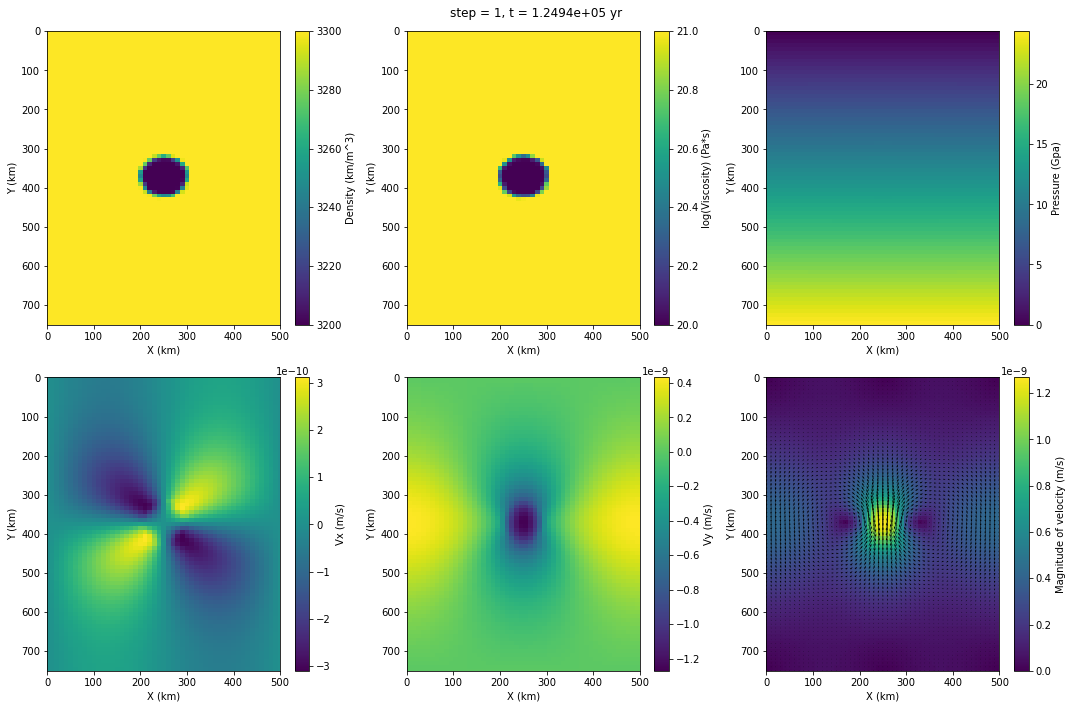

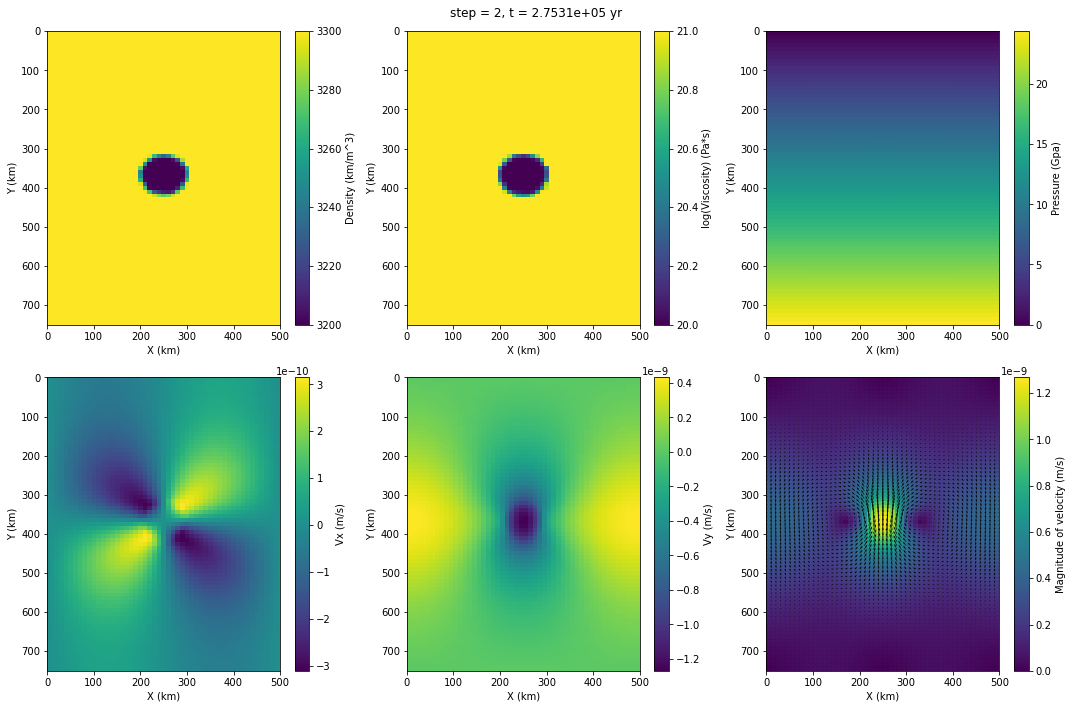

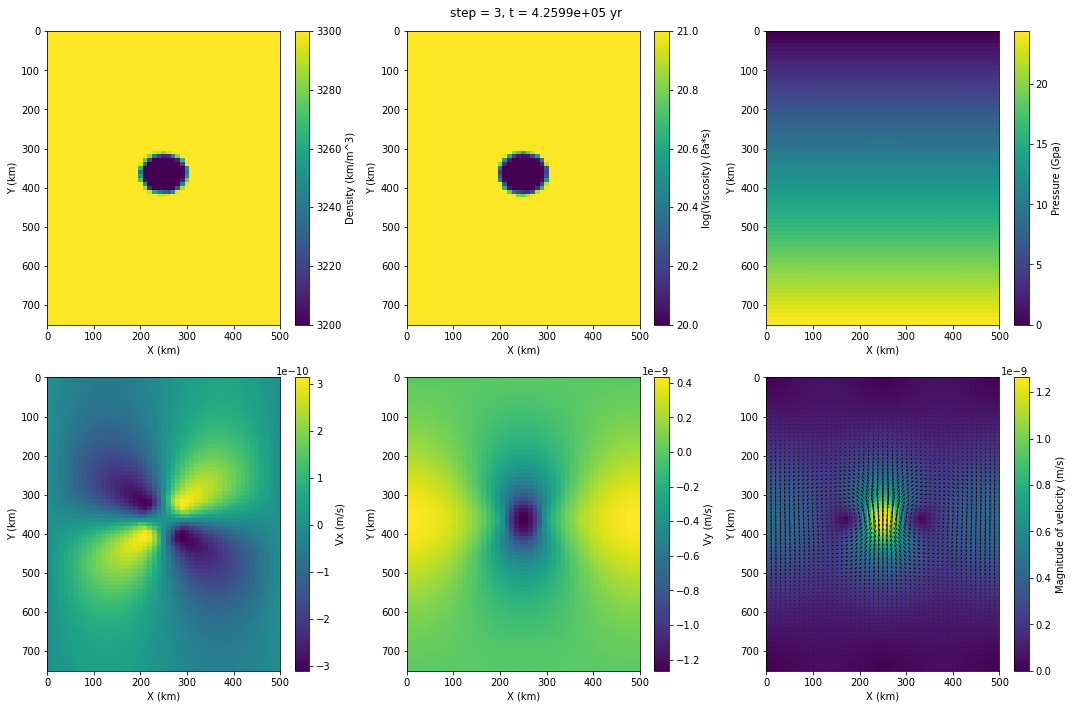

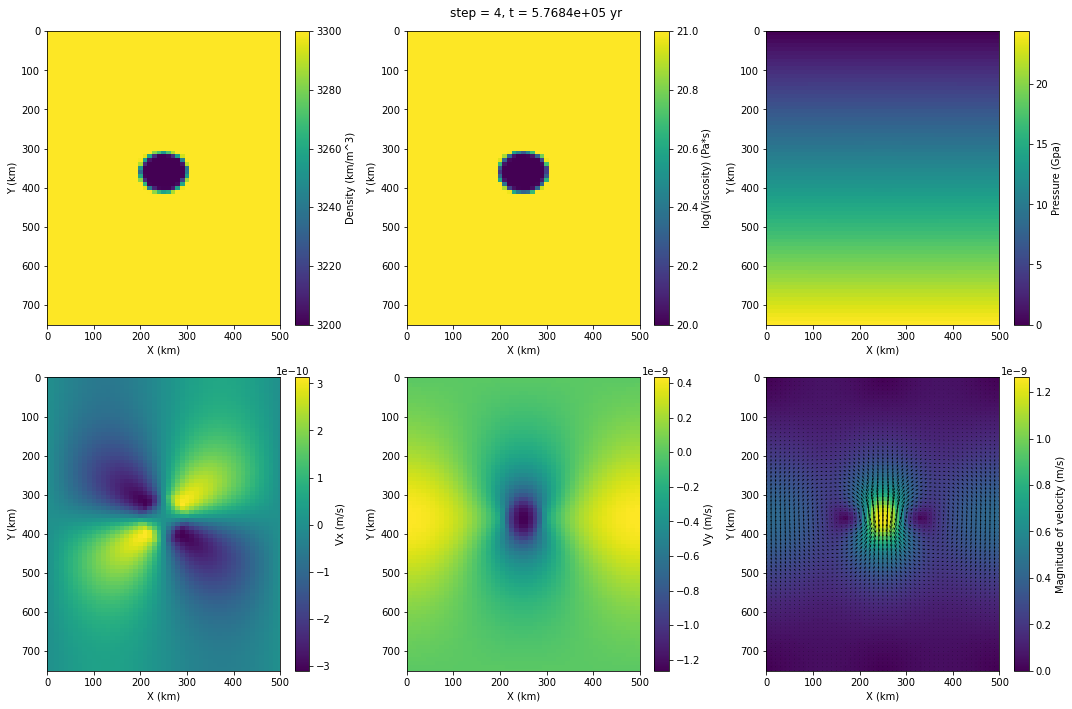

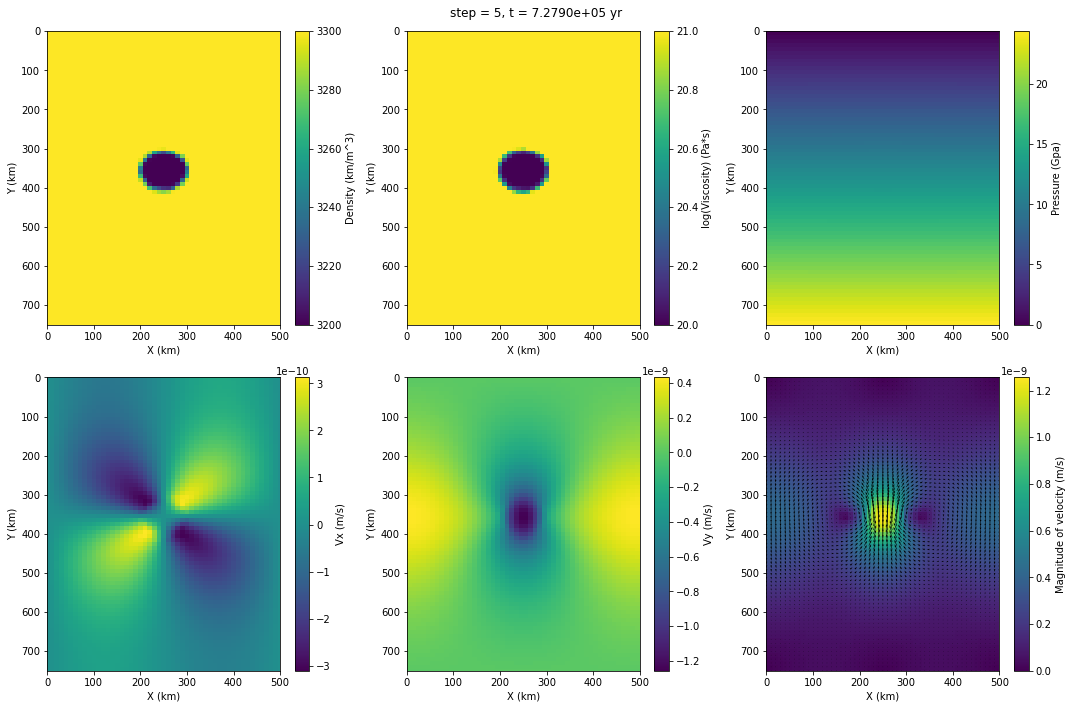

In [9]:
total_steps = 10 # total steps to solve
plot_per_step = 1  # plot every few steps
# assemble
print("Stokes_Continuity_Markers, step 0")
Solver.assemble()
Solver.solve()  # 0th step
for step in range(1, total_steps):
    print("Stokes_Continuity_Markers, step %d" % step)
    Solver.advect()
    Solver.assemble()
    Solver.solve()  
    plot_result(Mesh2d, Solver, Solver.MaterialModel)